In [ ]:
pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 900.5 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.6 MB/s eta 0:00:00


In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
import multiprocessing as mp
mp.set_start_method('spawn', force=True) #Added part

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
import torch
import tensorflow as tf
from tensorflow import keras
from typing import Optional, Union, Tuple
from pytorch_tabnet.tab_model import TabNetRegressor
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import tensorflow.python
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import sklearn
import sklearn.linear_model
import matplotlib
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
sns.set(rc={'figure.figsize':(11.7,8.27)})

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4504564810567979841
xla_global_id: -1
]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load the datasets
X_train_df = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/train_label.csv')
X_valid_df = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/valid_label.csv')
X_test_df = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/test_label.csv')

In [ ]:
# Exclude 'ID' and 'Global_Score_pro'
features = [col for col in X_train_df.columns if col not in ['ID', 'Global_Score_pro']]

# Initialize lists and dictionary for categorical features
categorical_columns = []
categorical_dims = {}

# Loop through features
for col in features:
    # Check if the column is not 'Age' (numerical feature)
    if col != 'Age':
        # Append the column to categorical_columns list
        categorical_columns.append(col)
        # Store the number of unique classes in the categorical_dims dictionary
        categorical_dims[col] = X_train_df[col].nunique()

# Print the lists and dictionary for verification
print("Categorical Columns:", categorical_columns)
print("Categorical Dimensions:", categorical_dims)

Categorical Columns: ['Nationality', 'Gender', 'Country_of_Residence', 'Ethnicity', 'Residence_Department_pro', 'Residence_Area_pro', 'University_Tuition_Fee_pro', 'Scholarship_Payment_pro', 'Credit_Payment_pro', 'Parent_Payment_pro', 'Self_Payment_pro', 'Father_Education_pro', 'Mother_Education_pro', 'Father_work_pro', 'Mother_work_pro', 'Housing_Stratum_pro', 'Internet_Access_pro', 'TV_Service_pro', 'Computer_Access_pro', 'Washing_Machine_Access_pro', 'Video_Game_Console_Access_pro', 'Shared_Bathroom_Count_pro', 'Car_Access_pro', 'Weekly_Working_Hours_pro', 'Motorcycle_Access_pro', 'Institution_Academic_Character_pro', 'Institution_Origin_pro', 'Group_Reference_pro', 'Student_Program_Method_pro', 'Institution_Department_pro', 'Stratum_Change', 'Computer_Access_Change', 'Washing_Machine_Access_Change', 'Car_Access_Change', 'Internet_Access_Change', 'Working_Hours_Change']
Categorical Dimensions: {'Nationality': 1, 'Gender': 2, 'Country_of_Residence': 1, 'Ethnicity': 20, 'Residence_Dep

In [ ]:
# Get indices of categorical features within the features list
categorical_indxs = [i for i, f in enumerate(features) if f in categorical_columns]

# Get corresponding categorical dimensions using categorical_dims dictionary
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [ ]:
# Extract the target variables
y_train = X_train_df['Global_Score_pro'].values.reshape(-1, 1)
y_valid = X_valid_df['Global_Score_pro'].values.reshape(-1, 1)
y_test = X_test_df['Global_Score_pro'].values.reshape(-1, 1)

# Drop 'ID' and 'Global_Score_pro' columns

X_train_df= X_train_df.drop(columns=['ID', 'Global_Score_pro'])
X_valid_df = X_valid_df.drop(columns=['ID', 'Global_Score_pro'])
X_test_df = X_test_df.drop(columns=['ID', 'Global_Score_pro'])

# Convert dataframes to numpy arrays
X_train = X_train_df.values
X_valid = X_valid_df.values
X_test = X_test_df.values


In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
tabnet_params = dict(

    n_d = 16,
    n_a = 16,
    n_steps = 9,
    gamma = 1.2,
    n_independent = 2,
    n_shared = 2,
    lambda_sparse = 0.00001,
    cat_idxs= categorical_indxs,
    cat_dims = cat_dims,
    optimizer_fn = Adam,
    optimizer_params = dict(lr = (2e-2)),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type = "sparsemax",
    seed = 42,
    verbose = 1,
    cat_emb_dim=1
)
reg_1 = TabNetRegressor(**tabnet_params)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:

reg_1.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mse'],
    max_epochs=200,
    patience=10,
    batch_size=8192,
    virtual_batch_size=128,
    num_workers=2,
    drop_last=False
)


epoch 0  | loss: 18338.32155| train_mse: 10815.81744| valid_mse: 10877.15741|  0:01:17s
epoch 1  | loss: 3425.06754| train_mse: 1248.8485| valid_mse: 1262.65586|  0:02:32s
epoch 2  | loss: 642.59873| train_mse: 863.86749| valid_mse: 875.11479|  0:03:46s
epoch 3  | loss: 555.70562| train_mse: 720.03493| valid_mse: 721.50912|  0:05:00s
epoch 4  | loss: 538.89407| train_mse: 559.64313| valid_mse: 560.46386|  0:06:16s
epoch 5  | loss: 531.52339| train_mse: 558.30527| valid_mse: 562.84547|  0:07:32s
epoch 6  | loss: 523.71145| train_mse: 557.85578| valid_mse: 558.30323|  0:08:51s
epoch 7  | loss: 523.98071| train_mse: 549.08145| valid_mse: 554.0687|  0:10:06s
epoch 8  | loss: 515.98429| train_mse: 566.5655| valid_mse: 569.04791|  0:11:23s
epoch 9  | loss: 515.9901| train_mse: 528.13352| valid_mse: 532.93091|  0:12:36s
epoch 10 | loss: 518.41163| train_mse: 532.22473| valid_mse: 536.76353|  0:13:51s
epoch 11 | loss: 508.19562| train_mse: 510.61083| valid_mse: 514.33589|  0:15:05s
epoch 12 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
# save tabnet model
saving_path_name = "/content/drive/MyDrive/Colab Notebooks/tabnet_model_test_1"
saved_filepath = reg_1.save_model(saving_path_name)

Successfully saved model at /content/drive/MyDrive/Colab Notebooks/tabnet_model_test_1.zip


In [ ]:
preds = reg_1.predict(X_test)
MSE = np.square(np.subtract(preds,y_test)).mean()

print(f"BEST VALID SCORE FOR {'Saber_pro'} : {reg_1.best_cost}")
print(f"FINAL TEST SCORE FOR {'Saber_pro'} : {MSE}")

BEST VALID SCORE FOR Saber_pro : 418.7609230452297
FINAL TEST SCORE FOR Saber_pro : 417.32360055956633


In [ ]:
def add_noise(X, noise_level=0.1):
    # Generate noise with the same shape as X
    noise = np.random.normal(scale=noise_level, size=X.shape)
    # Add noise to the original data
    X_noisy = X + noise
    return X_noisy

In [ ]:
# Assuming X_test is your test data
X_test_noisy = add_noise(X_test, noise_level=0.1)

# Predict on the noisy test data
preds_noisy = reg_1.predict(X_test_noisy)

# Calculate MSE on the noisy predictions
MSE_noisy = np.square(np.subtract(preds_noisy, y_test)).mean()

print(f"FINAL TEST SCORE FOR {'Saber_pro'} with noise injection: {MSE_noisy}")


FINAL TEST SCORE FOR Saber_pro with noise injection: 942.3758414322696


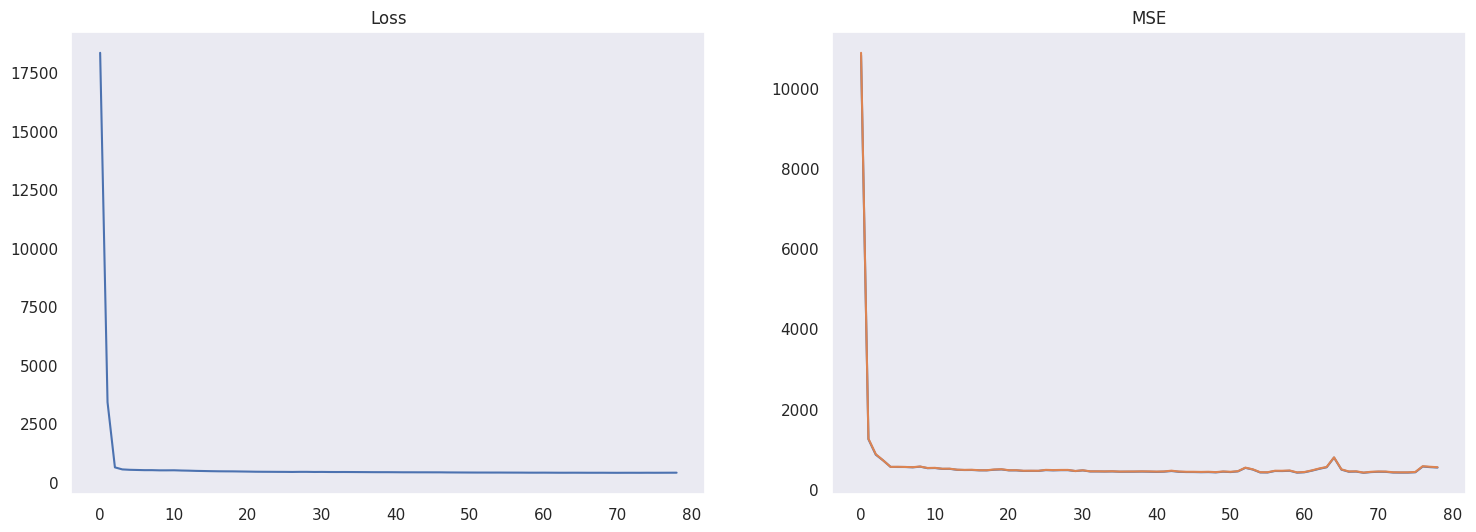

In [ ]:
plt.figure(figsize=[18, 6])
plt.subplot(1, 2, 1)
plt.plot(reg_1.history['loss'])
plt.title('Loss')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(reg_1.history['train_mse'])
plt.plot(reg_1.history['valid_mse'])
plt.title('MSE')
plt.grid()
plt.savefig("TabNet_performance.png", dpi=100)
plt.show()


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


  0%|          | 0/100 [00:00<?, ?it/s]

Shape of shap_values after squeeze: (100, 37)
Shape of X_sample: (100, 37)


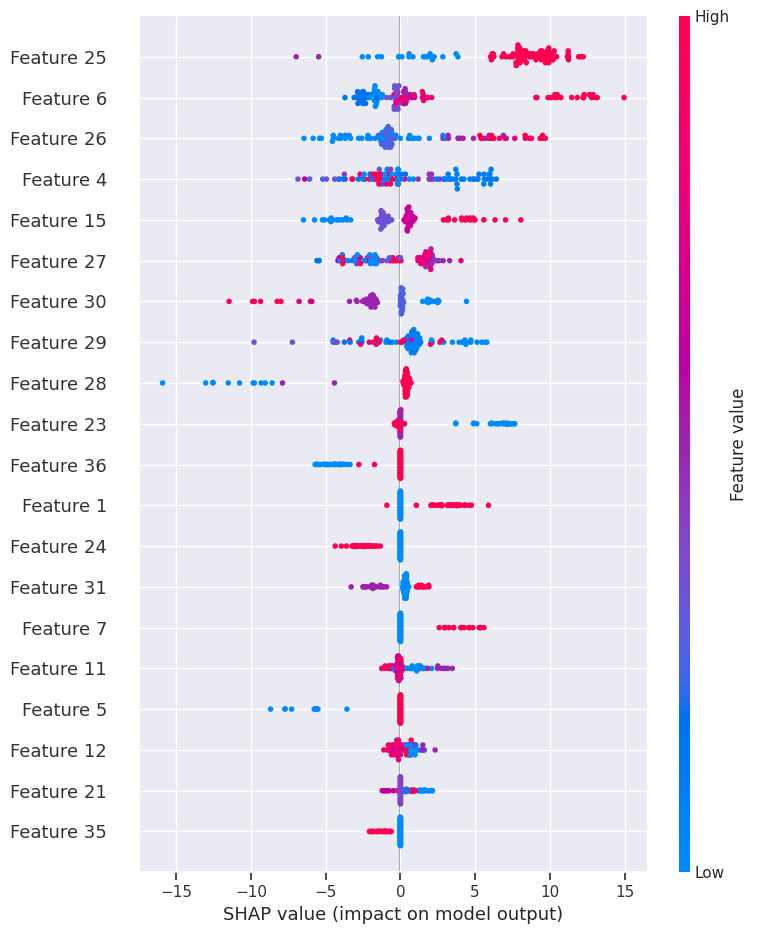

In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor
import shap
import numpy as np

# Load model
reg_loaded = TabNetRegressor()
reg_loaded.load_model('/content/drive/MyDrive/Colab Notebooks/tabnet_model_test_1.zip')

# Prepare background summary
background_summary = shap.kmeans(X_test, 50)

# Instantiate the explainer
explainer = shap.KernelExplainer(reg_loaded.predict, background_summary)

# Sample data
num_samples = 100
random_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
X_sample = X_test[random_indices]

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

# Remove the extra dimension
shap_values = np.squeeze(shap_values)
print(f"Shape of shap_values after squeeze: {shap_values.shape}")
print(f"Shape of X_sample: {X_sample.shape}")

# Ensure the shapes match
assert shap_values.shape == X_sample.shape, "Shape mismatch between SHAP values and input features."

# Plot the SHAP values for the first sample
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_sample[0])

# Optional: Plot summary plot for the sample
shap.summary_plot(shap_values, X_sample)


In [ ]:
feature_names = X_test_df.columns.tolist()


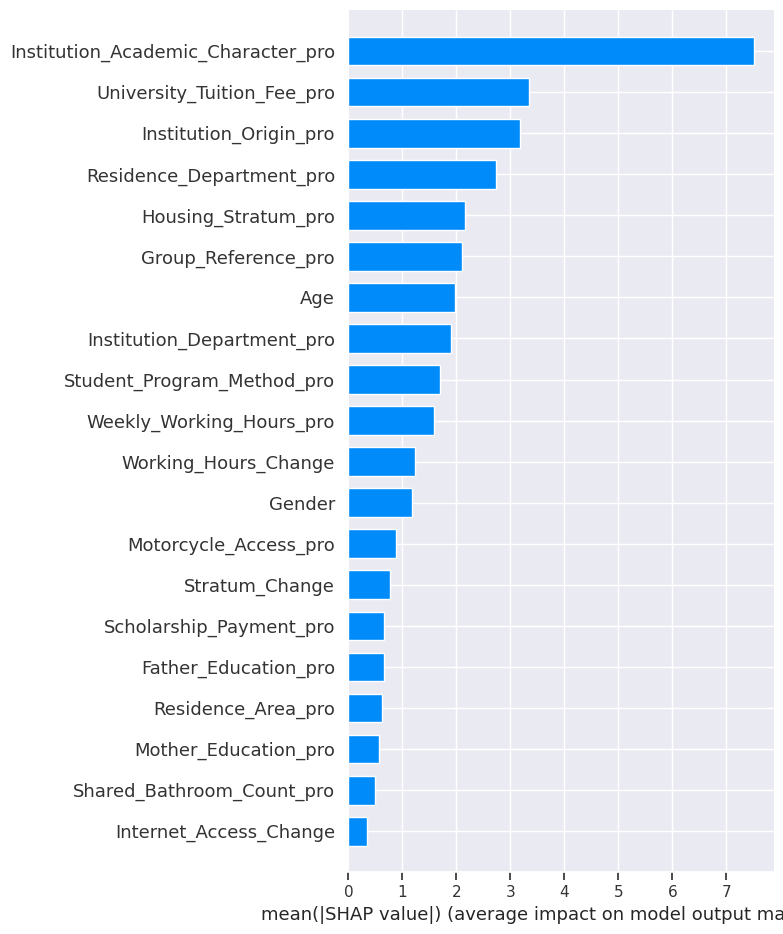

In [ ]:
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type = 'bar' )

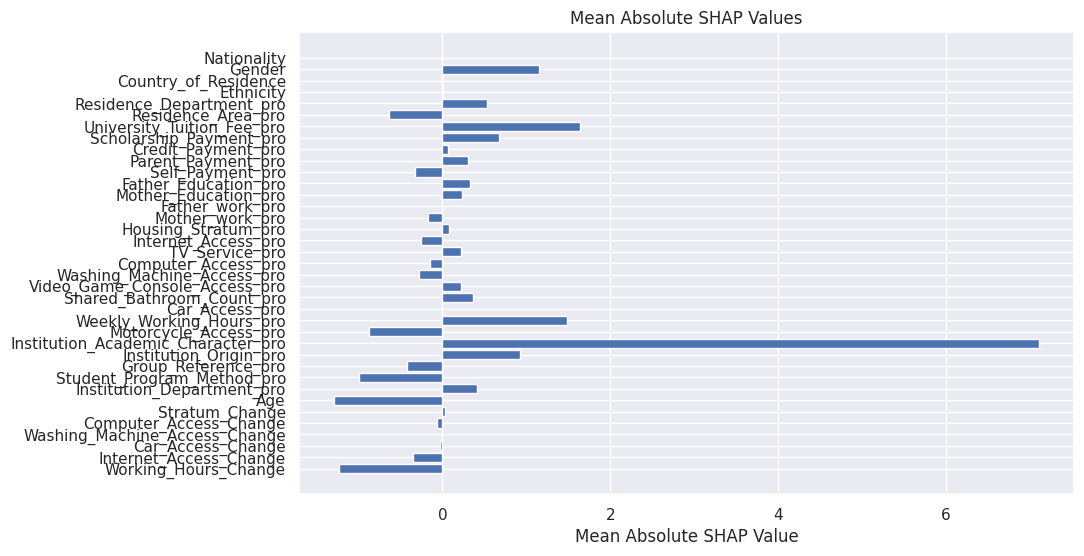

In [ ]:
mean_abs_shap_values = np.mean(shap_values, axis=0)

# Plot mean absolute SHAP values
plt.figure(figsize=(10, 6))
plt.barh(feature_names, mean_abs_shap_values)
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Mean Absolute SHAP Values')
plt.gca().invert_yaxis()  # Invert y-axis to display features from top to bottom
plt.show()